<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/LogFilters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [ ]:
class LaplacianOfGaussianFilter(tfkl.Layer):
    def __init__(self, dilation_rate, **kwds):
        super().__init__(**kwds)
        self.dilation_rate = dilation_rate

    def build(self, input_shape):
        laplacian_kernel = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])

        gaussian_kernel = (1.0/16.0) * np.array([
            [1.0, 2.0, 1.0],
            [2.0, 4.0, 2.0],
            [1.0, 2.0, 1.0]
        ])

        inp = tfkl.Input(input_shape[1:])

        x = inp

        gaussian_filter = tfkl.DepthwiseConv2D(kernel_size = (3, 3), dilation_rate = self.dilation_rate, padding = 'same', use_bias = False)
        laplacian_filter = tfkl.DepthwiseConv2D(kernel_size = (3, 3), dilation_rate = self.dilation_rate, padding = 'same', use_bias = False)

        x = gaussian_filter(x)
        x = laplacian_filter(x)
        x = tfkl.ReLU()(x)

        gaussian_filter.set_weights([np.stack([gaussian_kernel]*input_shape[-1], axis = -1)[..., np.newaxis]])
        laplacian_filter.set_weights([np.stack([laplacian_kernel]*input_shape[-1], axis = -1)[..., np.newaxis]])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)


In [ ]:
def create_encoder():
    inp = tfkl.Input([None, None, 3])

    x = inp
    x = tfkl.Rescaling(scale = 1./255.0, offset = 0)(x)

    for _ in range(4):
        res = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (1, 1))(x)
        x1 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (2, 2))(x)
        x2 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (3, 3))(x)
        x3 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (4, 4))(x)
        x4 = x

        x = tfkl.Concatenate(axis = -1)([res, x1, x2, x3, x4])
        x = tfkl.MaxPool2D((2, 2))(x)

    out = x

    model = tfkm.Model(inputs = [inp], outputs = [out], name = 'encoder')

    return model

In [ ]:
encoder_model = create_encoder()

In [ ]:
image = tfku.load_img('srk.jpg')
img_arr = tfku.img_to_array(image)

In [ ]:
img_arr.shape

(528, 1280, 3)

In [ ]:
X = img_arr[:512, :1280, :]
X = X[np.newaxis, ...]

In [ ]:
Y = encoder_model.predict(X)

1/1 [==============================] - 5s 5s/step


In [ ]:
Y = np.clip(Y, 0, 1)

In [ ]:
Y = np.uint8(255 * (Y))

In [ ]:
np.sqrt(9375 / 3)

55.90169943749474

In [ ]:
1875 / 3

625.0

In [ ]:
i_list = []
for idx in range(25):
    j_list = []
    for jdx in range(25):
        ptr = idx * 25 + jdx
        j_list += [Y[0, :, :, 3 * ptr : 3 * (ptr + 1)]]
    j_img = np.concatenate(j_list, axis = 1)
    i_list += [j_img]
img_fin = np.concatenate(i_list, axis = 0)

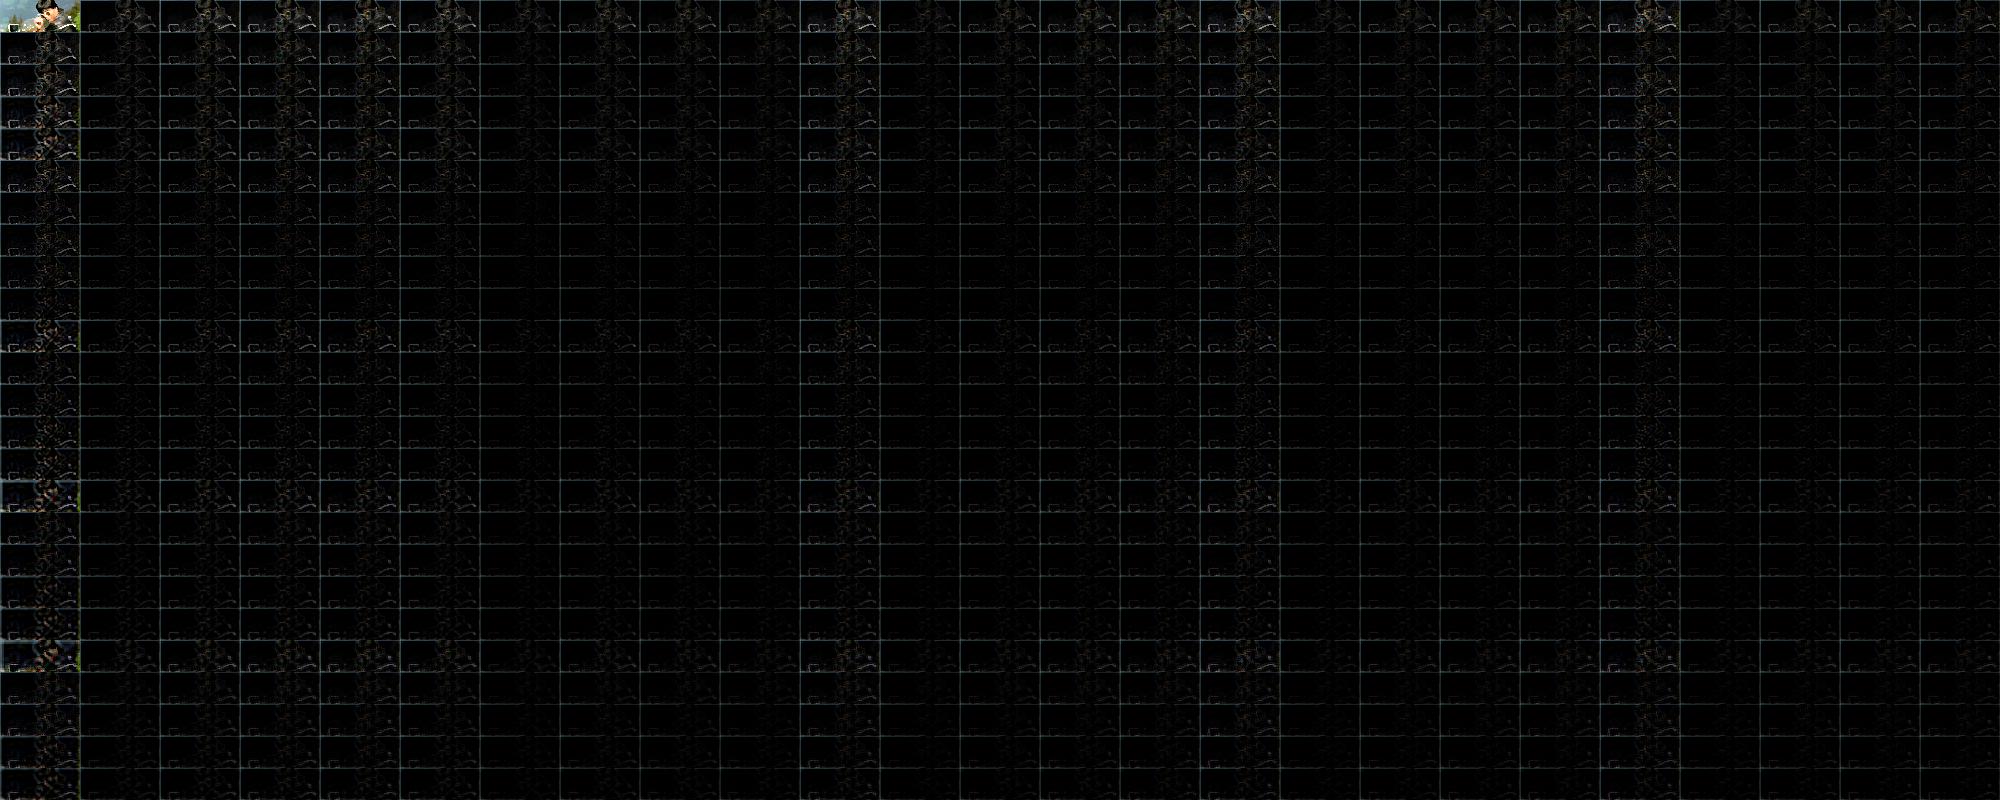

In [ ]:
tfku.array_to_img(img_fin)

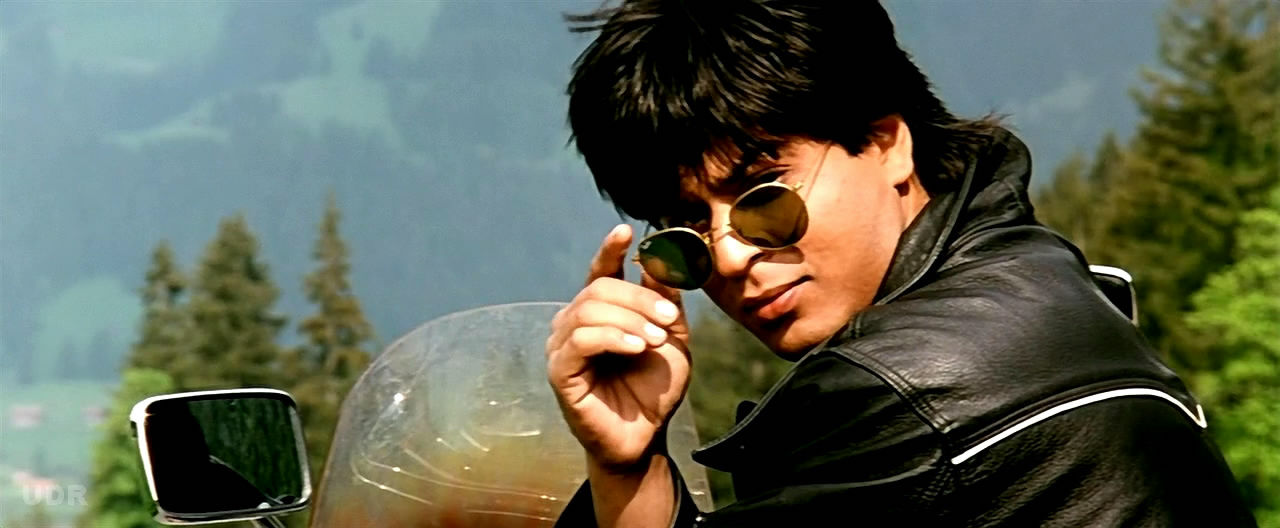

In [ ]:
image